<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

## Libraries Import  

<br/><br/>

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import plot_confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import plot_roc_curve, RocCurveDisplay, roc_auc_score
from sklearn.metrics import plot_precision_recall_curve, PrecisionRecallDisplay, average_precision_score
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [4]:
# run to avoid warnings
import warnings
warnings.filterwarnings('ignore')

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovateable:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [5]:
# load the data
house = pd.read_csv('datasets/housing.csv')

In [6]:
# look at the dataset
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
# check the shape
house.shape

(1460, 81)

In [8]:
# check the info
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [9]:
# check the statistical summary
house.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [10]:
# check for duplicate rows
house.duplicated().sum()

0

In [11]:
# drop Id column
house.drop(columns='Id', inplace=True)

In [ ]:
# build a data dictionary
data_dict = {'MSSubClass':['Identifies the type of dwelling involved in the sale', 'fixed', 'nomi'],
             'MSZoning':['Identifies the general zoning classification of the sale', 'fixed', 'nomi'],
             'LotFrontage':['Linear feet of street connected to property', 'fixed', 'cont'],
             'LotArea':['Lot size in square feet', 'fixed', 'cont'],
             'Street':['Type of road access to property', 'mutable', 'nomi'],
             'Alley':['Type of alley access to property', 'mutable', 'nomi'], 
             'LotShape':['General shape of property', 'fixed', 'nomi'], 
             'LandContour':['Flatness of the property', 'fixed', 'nomi'], 
             'Utilities':['Type of utilities available', 'mutable', 'nomi'], 
             'LotConfig':['Lot configuration', 'fixed', 'nomi'],
             'LandSlope':['Slope of property', 'fixed', 'nomi'], 
             'Neighborhood':['Physical locations within Ames city limits', 'fixed', 'nomi'], 
             'Condition1':['Proximity to various conditions', 'fixed', 'nomi'], 
             'Condition2':['Proximity to various conditions (if more than one is present)', 'fixed', 'nomi'], 
             'BldgType':['Type of dwelling', 'fixed', 'nomi'],
             'HouseStyle':['Style of dwelling', 'fixed', 'nomi'], 
             'OverallQual':['Rates the overall material and finish of the house', 'mutable', 'ordi'], 
             'OverallCond':['Rates the overall condition of the house','mutable', 'ordi'], 
             'YearBuilt':['Original construction date', 'fixed', 'disc'], 
             'YearRemodAdd':['Remodel date (same as construction date if no remodeling or additions)', 'fixed', 'disc'],
             'RoofStyle':['Type of roof', 'fixed', 'nomi'], 
             'RoofMatl':['Roof material', 'mutable', 'nomi'], 
             'Exterior1st':['Exterior covering on house', 'mutable', 'nomi'], 
             'Exterior2nd':['Exterior covering on house (if more than one material)', 'mutable', 'nomi'], 
             'MasVnrType':['Masonry veneer type', 'mutable', 'nomi'],
             'MasVnrArea':['Masonry veneer area in square feet', 'mutable', 'cont'], 
             'ExterQual':['Evaluates the quality of the material on the exterior', 'mutable', 'nomi'], 
             'ExterCond':['Evaluates the present condition of the material on the exterior', 'mutable', 'nomi'], 
             'Foundation':['Type of foundation', 'fixed', 'nomi'], 
             'BsmtQual':['Evaluates the height of the basement', 'mutable', 'nomi'],
             'BsmtCond':['Evaluates the general condition of the basement', 'mutable', 'nomi'], 
             'BsmtExposure':['Refers to walkout or garden level walls', 'fixed', 'nomi'], 
             'BsmtFinType1':['Rating of basement finished area', 'mutable', 'nomi'], 
             'BsmtFinSF1':['Type 1 finished square feet', 'fixed', 'cont'],
             'BsmtFinType2':['Rating of basement finished area (if multiple types)', 'mutable', 'nomi'], 
             'BsmtFinSF2':['Type 2 finished square feet', 'fixed', 'cont'], 
             'BsmtUnfSF':['Unfinished square feet of basement area', 'fixed', 'cont'], 
             'TotalBsmtSF':['Total square feet of basement area', 'fixed', 'cont'], 
             'Heating':['Type of heating', 'mutable', 'nomi'],
             'HeatingQC':['Heating quality and condition', 'mutable', 'nomi'], 
             'CentralAir':['Central air conditioning', 'mutable', 'ordi'], 
             'Electrical':['Electrical system', 'mutable', 'nomi'], 
             '1stFlrSF':['First Floor square feet','fixed', 'cont'], 
             '2ndFlrSF':['Second floor square feet','fixed', 'cont'],
             'LowQualFinSF':['Low quality finished square feet (all floors)', 'mutable', 'cont'], 
             'GrLivArea':['Above grade (ground) living area square feet', 'fixed', 'cont'], 
             'BsmtFullBath':['Basement full bathrooms', 'mutable', 'disc'], 
             'BsmtHalfBath':['Basement half bathrooms', 'mutable', 'disc'], 
             'FullBath':['Full bathrooms above grade', 'mutable', 'disc'],
             'HalfBath':['Half baths above grade', 'mutable', 'disc'], 
             'BedroomAbvGr':['Bedrooms above grade (does NOT include basement bedrooms)', 'mutable', 'disc'], 
             'KitchenAbvGr':['Kitchens above grade', 'mutable', 'disc'], 
             'KitchenQual':['Kitchen quality', 'mutable', 'nomi'],
             'TotRmsAbvGrd':['Total rooms above grade (does not include bathrooms)', 'fixed', 'disc'], 
             'Functional':['Home functionality (Assume typical unless deductions are warranted)', 'mutable', 'nomi'], 
             'Fireplaces':['Number of fireplaces', 'fixed', 'disc'], 
             'FireplaceQu':['Fireplace quality', 'mutable', 'nomi'], 
             'GarageType':['Garage location','fixed','nomi'],
             'GarageYrBlt':['Year garage was built','fixed','disc'], 
             'GarageFinish':['Interior finish of the garage','mutable','nomi'], 
             'GarageCars':['Size of garage in car capacity','fixed','disc'], 
             'GarageArea':['Size of garage in square feet','fixed','cont'], 
             'GarageQual':['Garage quality','mutable','nomi'],
             'GarageCond':['Garage condition','mutable','nomi'], 
             'PavedDrive':['Paved driveway','mutable','nomi'], 
             'WoodDeckSF':['Wood deck area in square feet','fixed','cont'], 
             'OpenPorchSF':['Open porch area in square feet','fixed','cont'],
             'EnclosedPorch':['Enclosed porch area in square feet','fixed','cont'], 
             '3SsnPorch':['Three season porch area in square feet','fixed','cont'], 
             'ScreenPorch':['Screen porch area in square feet','fixed','cont'], 
             'PoolArea':['Pool area in square feet','fixed','cont'], 
             'PoolQC':['Pool quality','mutable','cat'],
             'Fence':['Fence quality','mutable','cat'], 
             'MiscFeature':['Miscellaneous feature not covered in other categories','fixed','cat'], 
             'MiscVal':['$Value of miscellaneous feature','fixed','cont'], 
             'MoSold':['Month Sold (MM)','fixed','cat'], 
             'YrSold':['Year Sold (YYYY)','fixed','cont'], 
             'SaleType':['Type of sale','fixed','cat'],
             'SaleCondition':['Condition of sale','fixed','cat'], 
             'SalePrice':['Value of property at sale','fixed','price']}

In [ ]:
continuous_vars = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
                   '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
                   '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

discrete_vars = ['YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
                 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'MoSold', 'YrSold']

ordinal_vars = ['OverallQual', 'OverallCond', 'CentralAir']

nominal_vars = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
                'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
                'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
                'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'Electrical', 'KitchenQual', 'Functional',
                'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence',
                'MiscFeature', 'SaleType', 'SaleCondition']

quant_vars = continuous_vars + discrete_vars

categ_vars = ordinal_vars + nominal_vars

price = ['SalePrice']

### UNTIL HERE

In [7]:
# remove any houses that are not residential from the dataset.
# check MSZoning column

house['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [8]:
# remove non-residential properties from the dataset

house = house[(house['MSZoning'] == 'RH') | (house['MSZoning'] == 'RL') | (house['MSZoning'] == 'RP') |
              (house['MSZoning'] == 'RM')]

In [9]:
house['MSZoning'].value_counts()

RL    1151
RM     218
RH      16
Name: MSZoning, dtype: int64

In [11]:
house.shape

(1385, 80)

In [12]:
house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1385 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1385 non-null   int64  
 1   MSZoning       1385 non-null   object 
 2   LotFrontage    1134 non-null   float64
 3   LotArea        1385 non-null   int64  
 4   Street         1385 non-null   object 
 5   Alley          65 non-null     object 
 6   LotShape       1385 non-null   object 
 7   LandContour    1385 non-null   object 
 8   Utilities      1385 non-null   object 
 9   LotConfig      1385 non-null   object 
 10  LandSlope      1385 non-null   object 
 11  Neighborhood   1385 non-null   object 
 12  Condition1     1385 non-null   object 
 13  Condition2     1385 non-null   object 
 14  BldgType       1385 non-null   object 
 15  HouseStyle     1385 non-null   object 
 16  OverallQual    1385 non-null   int64  
 17  OverallCond    1385 non-null   int64  
 18  YearBuil

In [13]:
# check Alley column.

house.Alley.value_counts()

Grvl    50
Pave    15
Name: Alley, dtype: int64

In [14]:
# check FireplaceQu column.

house.FireplaceQu.value_counts()

Gd    363
TA    306
Fa     32
Ex     23
Po     20
Name: FireplaceQu, dtype: int64

In [15]:
# check PoolQC column.

house.PoolQC.value_counts()

Gd    3
Ex    2
Fa    2
Name: PoolQC, dtype: int64

In [16]:
# check Fence column.

house.Fence.value_counts()

MnPrv    155
GdPrv     59
GdWo      52
MnWw      11
Name: Fence, dtype: int64

In [17]:
# check MiscFeature column.

house.MiscFeature.value_counts()

Shed    47
Gar2     2
Othr     2
TenC     1
Name: MiscFeature, dtype: int64

In [ ]:
# Some features seem to have a lot of missing values (NaN).
# However the data description indicates that 'NA' means the property does not have a particular feature, rather than being a
# missing value.
# I will replace the 'NA' values with 'No' so they will be not counted as missing values.




In [18]:
# replace NA with No

Cols_using_NA = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType',
           'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

house[Cols_using_NA] = house[Cols_using_NA].replace({'NA': 'No', np.nan: 'No'})


In [96]:
house.groupby('Alley')['SalePrice'].median().sort_values()

Alley
Grvl    119500.0
Pave    159434.0
No      162950.0
Name: SalePrice, dtype: float64

In [97]:
house.groupby('Alley')['SalePrice'].mean().sort_values()

Alley
Grvl    122219.080000
Pave    168127.533333
No      182179.878995
Name: SalePrice, dtype: float64

In [98]:
house.groupby('BsmtQual')['SalePrice'].median().sort_values()

BsmtQual
No    101800.0
Fa    112000.0
TA    136250.0
Gd    192000.0
Ex    318000.0
Name: SalePrice, dtype: float64

In [99]:
house.groupby('BsmtQual')['SalePrice'].mean().sort_values()

BsmtQual
No    105652.891892
Fa    115692.028571
TA    141704.103448
Gd    202559.558348
Ex    328803.196429
Name: SalePrice, dtype: float64

In [100]:
house.groupby('BsmtCond')['SalePrice'].median().sort_values()

BsmtCond
Po     64000.0
No    101800.0
Fa    118500.0
TA    163000.0
Gd    191570.0
Name: SalePrice, dtype: float64

In [101]:
house.groupby('BsmtCond')['SalePrice'].mean().sort_values()

BsmtCond
Po     64000.000000
No    105652.891892
Fa    122384.395349
TA    182800.968472
Gd    209879.066667
Name: SalePrice, dtype: float64

In [102]:
house.groupby('BsmtExposure')['SalePrice'].mean().sort_values()

BsmtExposure
No    161771.936559
Mn    190677.462264
Av    206152.771429
Gd    256131.082707
Name: SalePrice, dtype: float64

In [103]:
house.groupby('BsmtExposure')['SalePrice'].median().sort_values()

BsmtExposure
No    147750.0
Mn    174000.0
Av    185250.0
Gd    225000.0
Name: SalePrice, dtype: float64

In [19]:
house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1385 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1385 non-null   int64  
 1   MSZoning       1385 non-null   object 
 2   LotFrontage    1134 non-null   float64
 3   LotArea        1385 non-null   int64  
 4   Street         1385 non-null   object 
 5   Alley          1385 non-null   object 
 6   LotShape       1385 non-null   object 
 7   LandContour    1385 non-null   object 
 8   Utilities      1385 non-null   object 
 9   LotConfig      1385 non-null   object 
 10  LandSlope      1385 non-null   object 
 11  Neighborhood   1385 non-null   object 
 12  Condition1     1385 non-null   object 
 13  Condition2     1385 non-null   object 
 14  BldgType       1385 non-null   object 
 15  HouseStyle     1385 non-null   object 
 16  OverallQual    1385 non-null   int64  
 17  OverallCond    1385 non-null   int64  
 18  YearBuil

In [20]:
house.Alley.value_counts()

No      1320
Grvl      50
Pave      15
Name: Alley, dtype: int64

In [21]:
# check YearBuilt column

house.YearBuilt.unique()

array([2003, 1976, 2001, 1915, 2000, 1993, 2004, 1973, 1931, 1939, 1965,
       2005, 1962, 2006, 1960, 1929, 1970, 1967, 1958, 1930, 2002, 1968,
       2007, 1951, 1957, 1927, 1966, 1959, 1994, 1954, 1953, 1955, 1983,
       1975, 1920, 1997, 1934, 1963, 1981, 1964, 1972, 1921, 1945, 1982,
       1998, 1956, 1948, 1910, 1995, 1991, 1950, 1961, 1999, 1977, 1985,
       1979, 2009, 1885, 1919, 1990, 1969, 1935, 1988, 1971, 1952, 1936,
       1923, 1924, 1984, 1926, 1940, 1941, 1987, 1986, 2008, 1908, 1892,
       1916, 1932, 1918, 1912, 1947, 1925, 1900, 1980, 1989, 1992, 1949,
       1880, 1928, 1978, 1922, 1996, 2010, 1946, 1913, 1937, 1942, 1938,
       1974, 1893, 1914, 1906, 1890, 1898, 1904, 1882, 1875, 1911, 1917,
       1872, 1905], dtype=int64)

In [22]:
# check YrSold column

house.YrSold.unique()

array([2008, 2007, 2006, 2009, 2010], dtype=int64)

In [118]:
continuous_vars = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
                   '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
                   '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

discrete_vars = ['YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
                 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'MoSold', 'YrSold']

ordinal_vars = ['OverallQual', 'OverallCond', 'CentralAir']

nominal_vars = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
                'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
                'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
                'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'Electrical', 'KitchenQual', 'Functional',
                'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence',
                'MiscFeature', 'SaleType', 'SaleCondition']

quant_vars = continuous_vars + discrete_vars

categ_vars = ordinal_vars + nominal_vars

price = ['SalePrice']

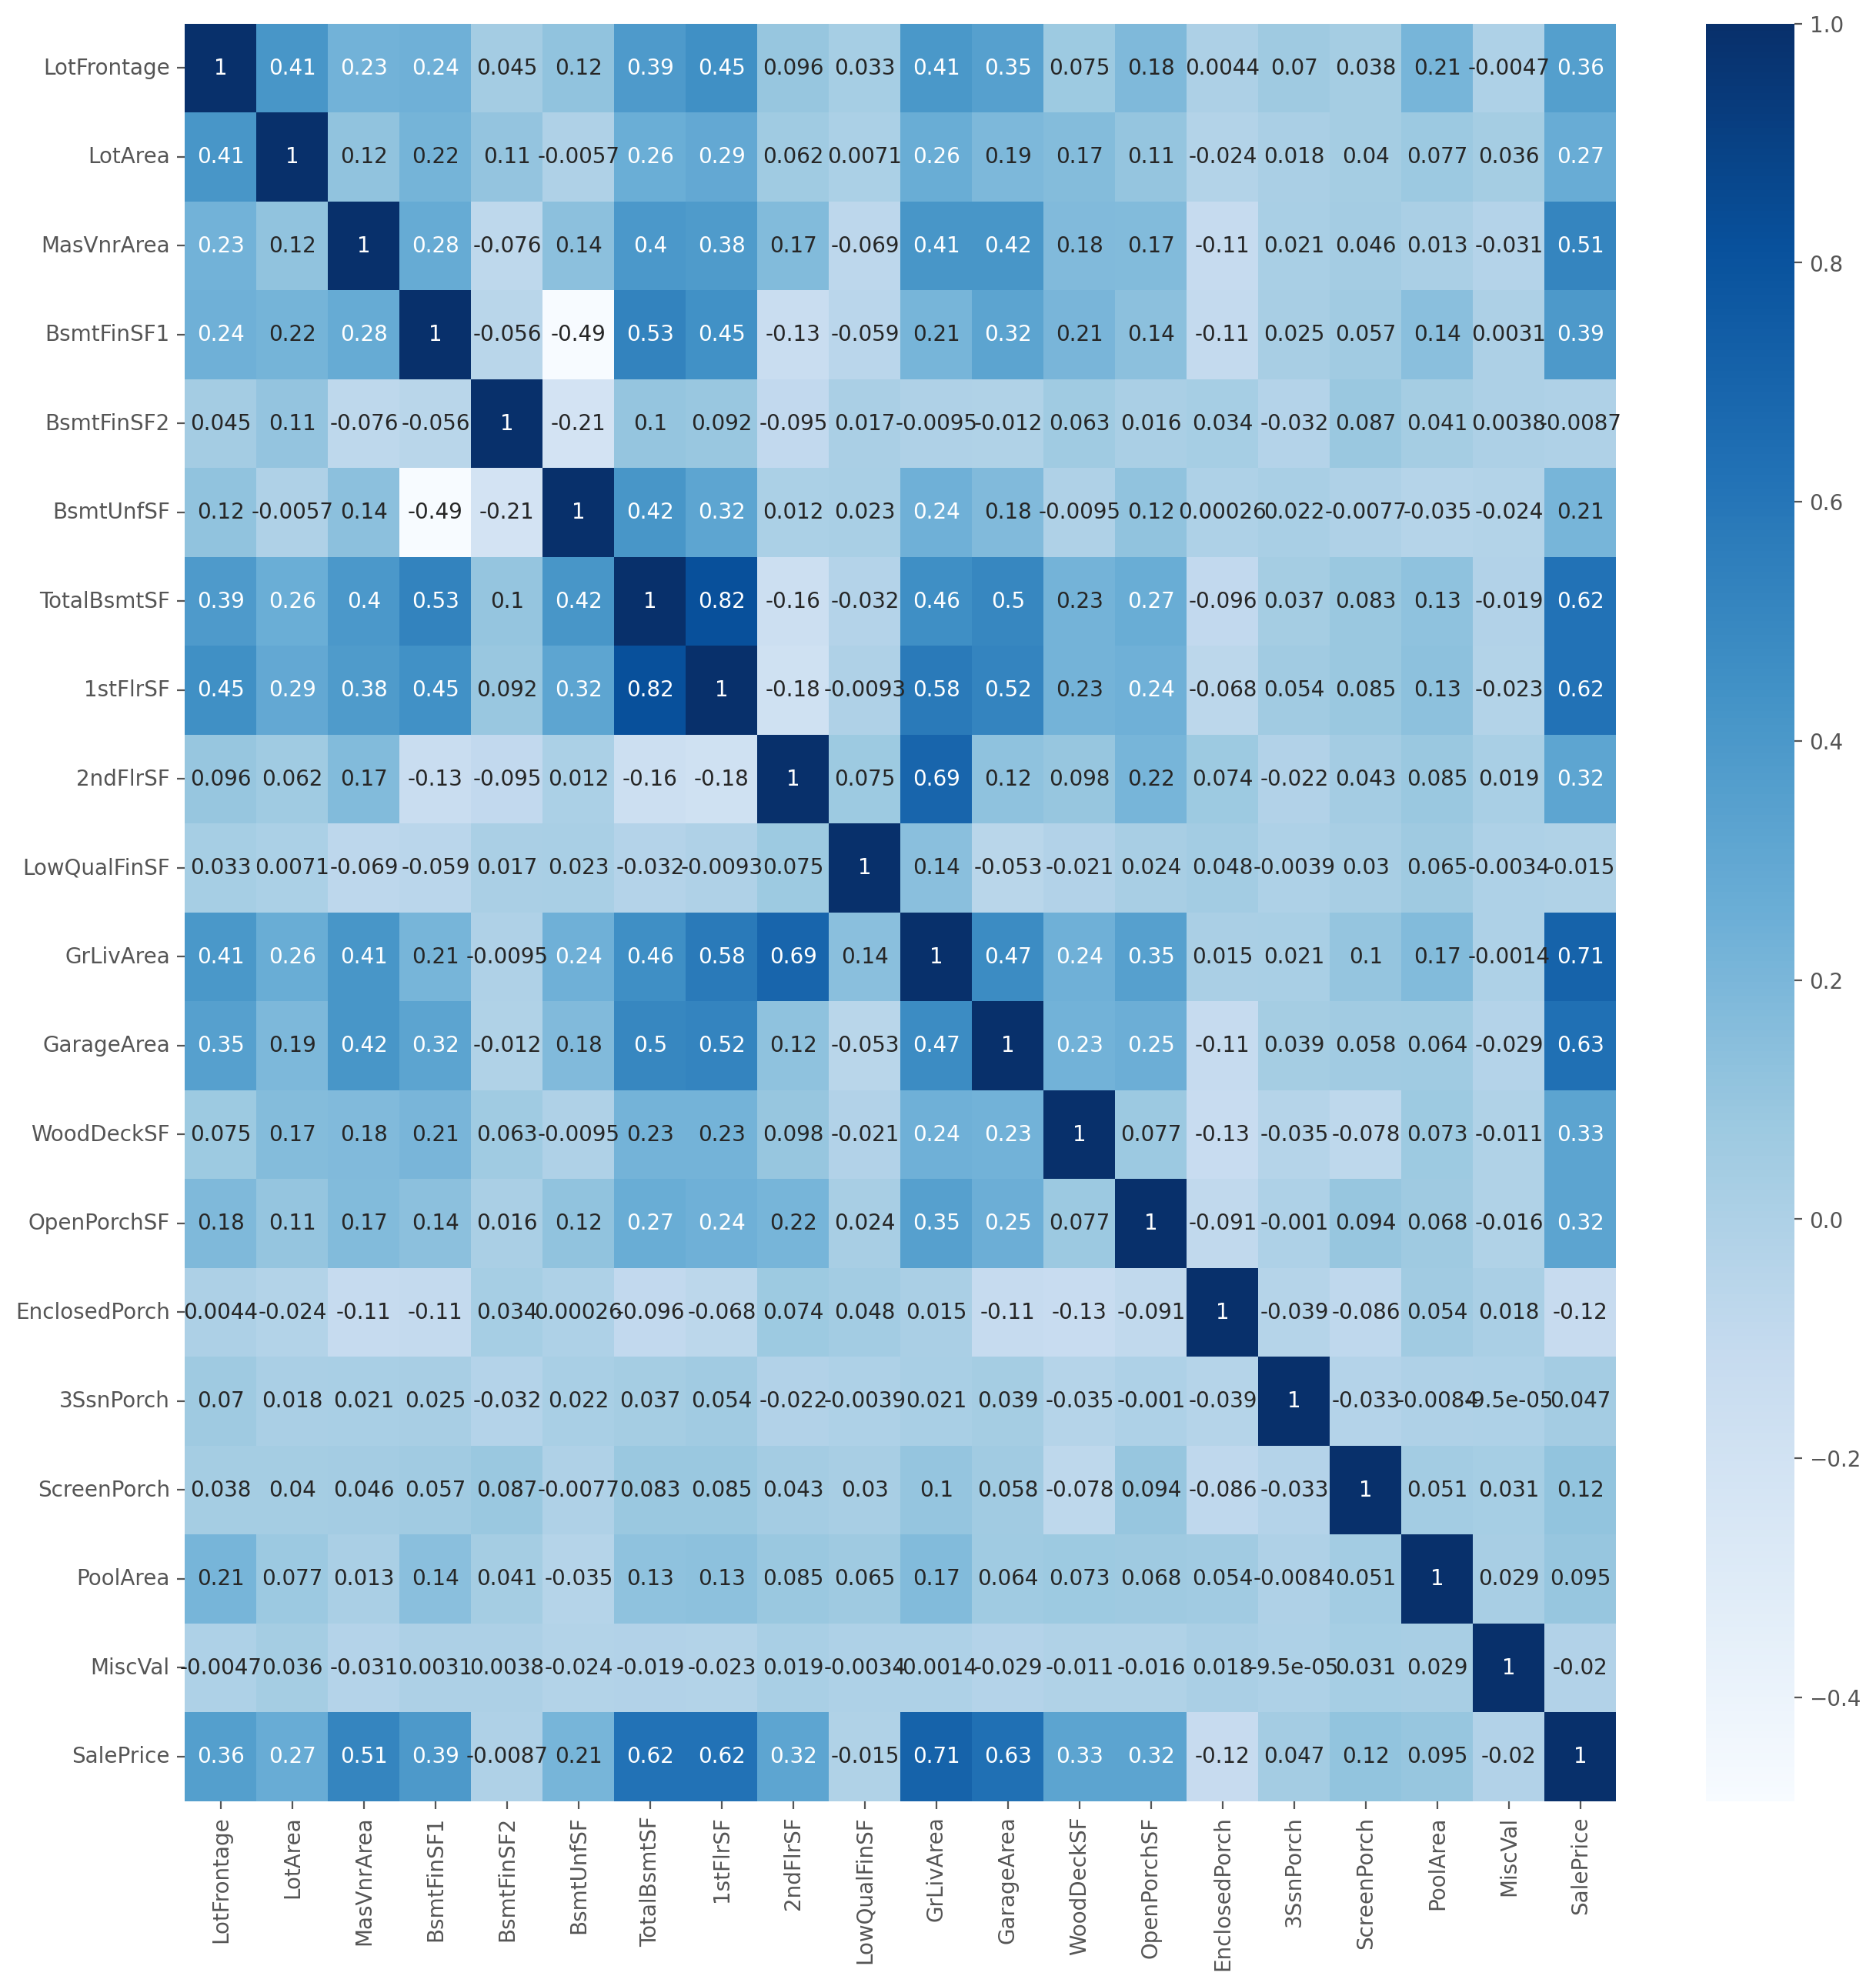

In [33]:
# explore correlations between continuous variables and price

plt.figure(figsize=(15, 15))
sns.heatmap(house[continuous_vars+price].corr(), cmap='Blues', annot=True)
plt.show;

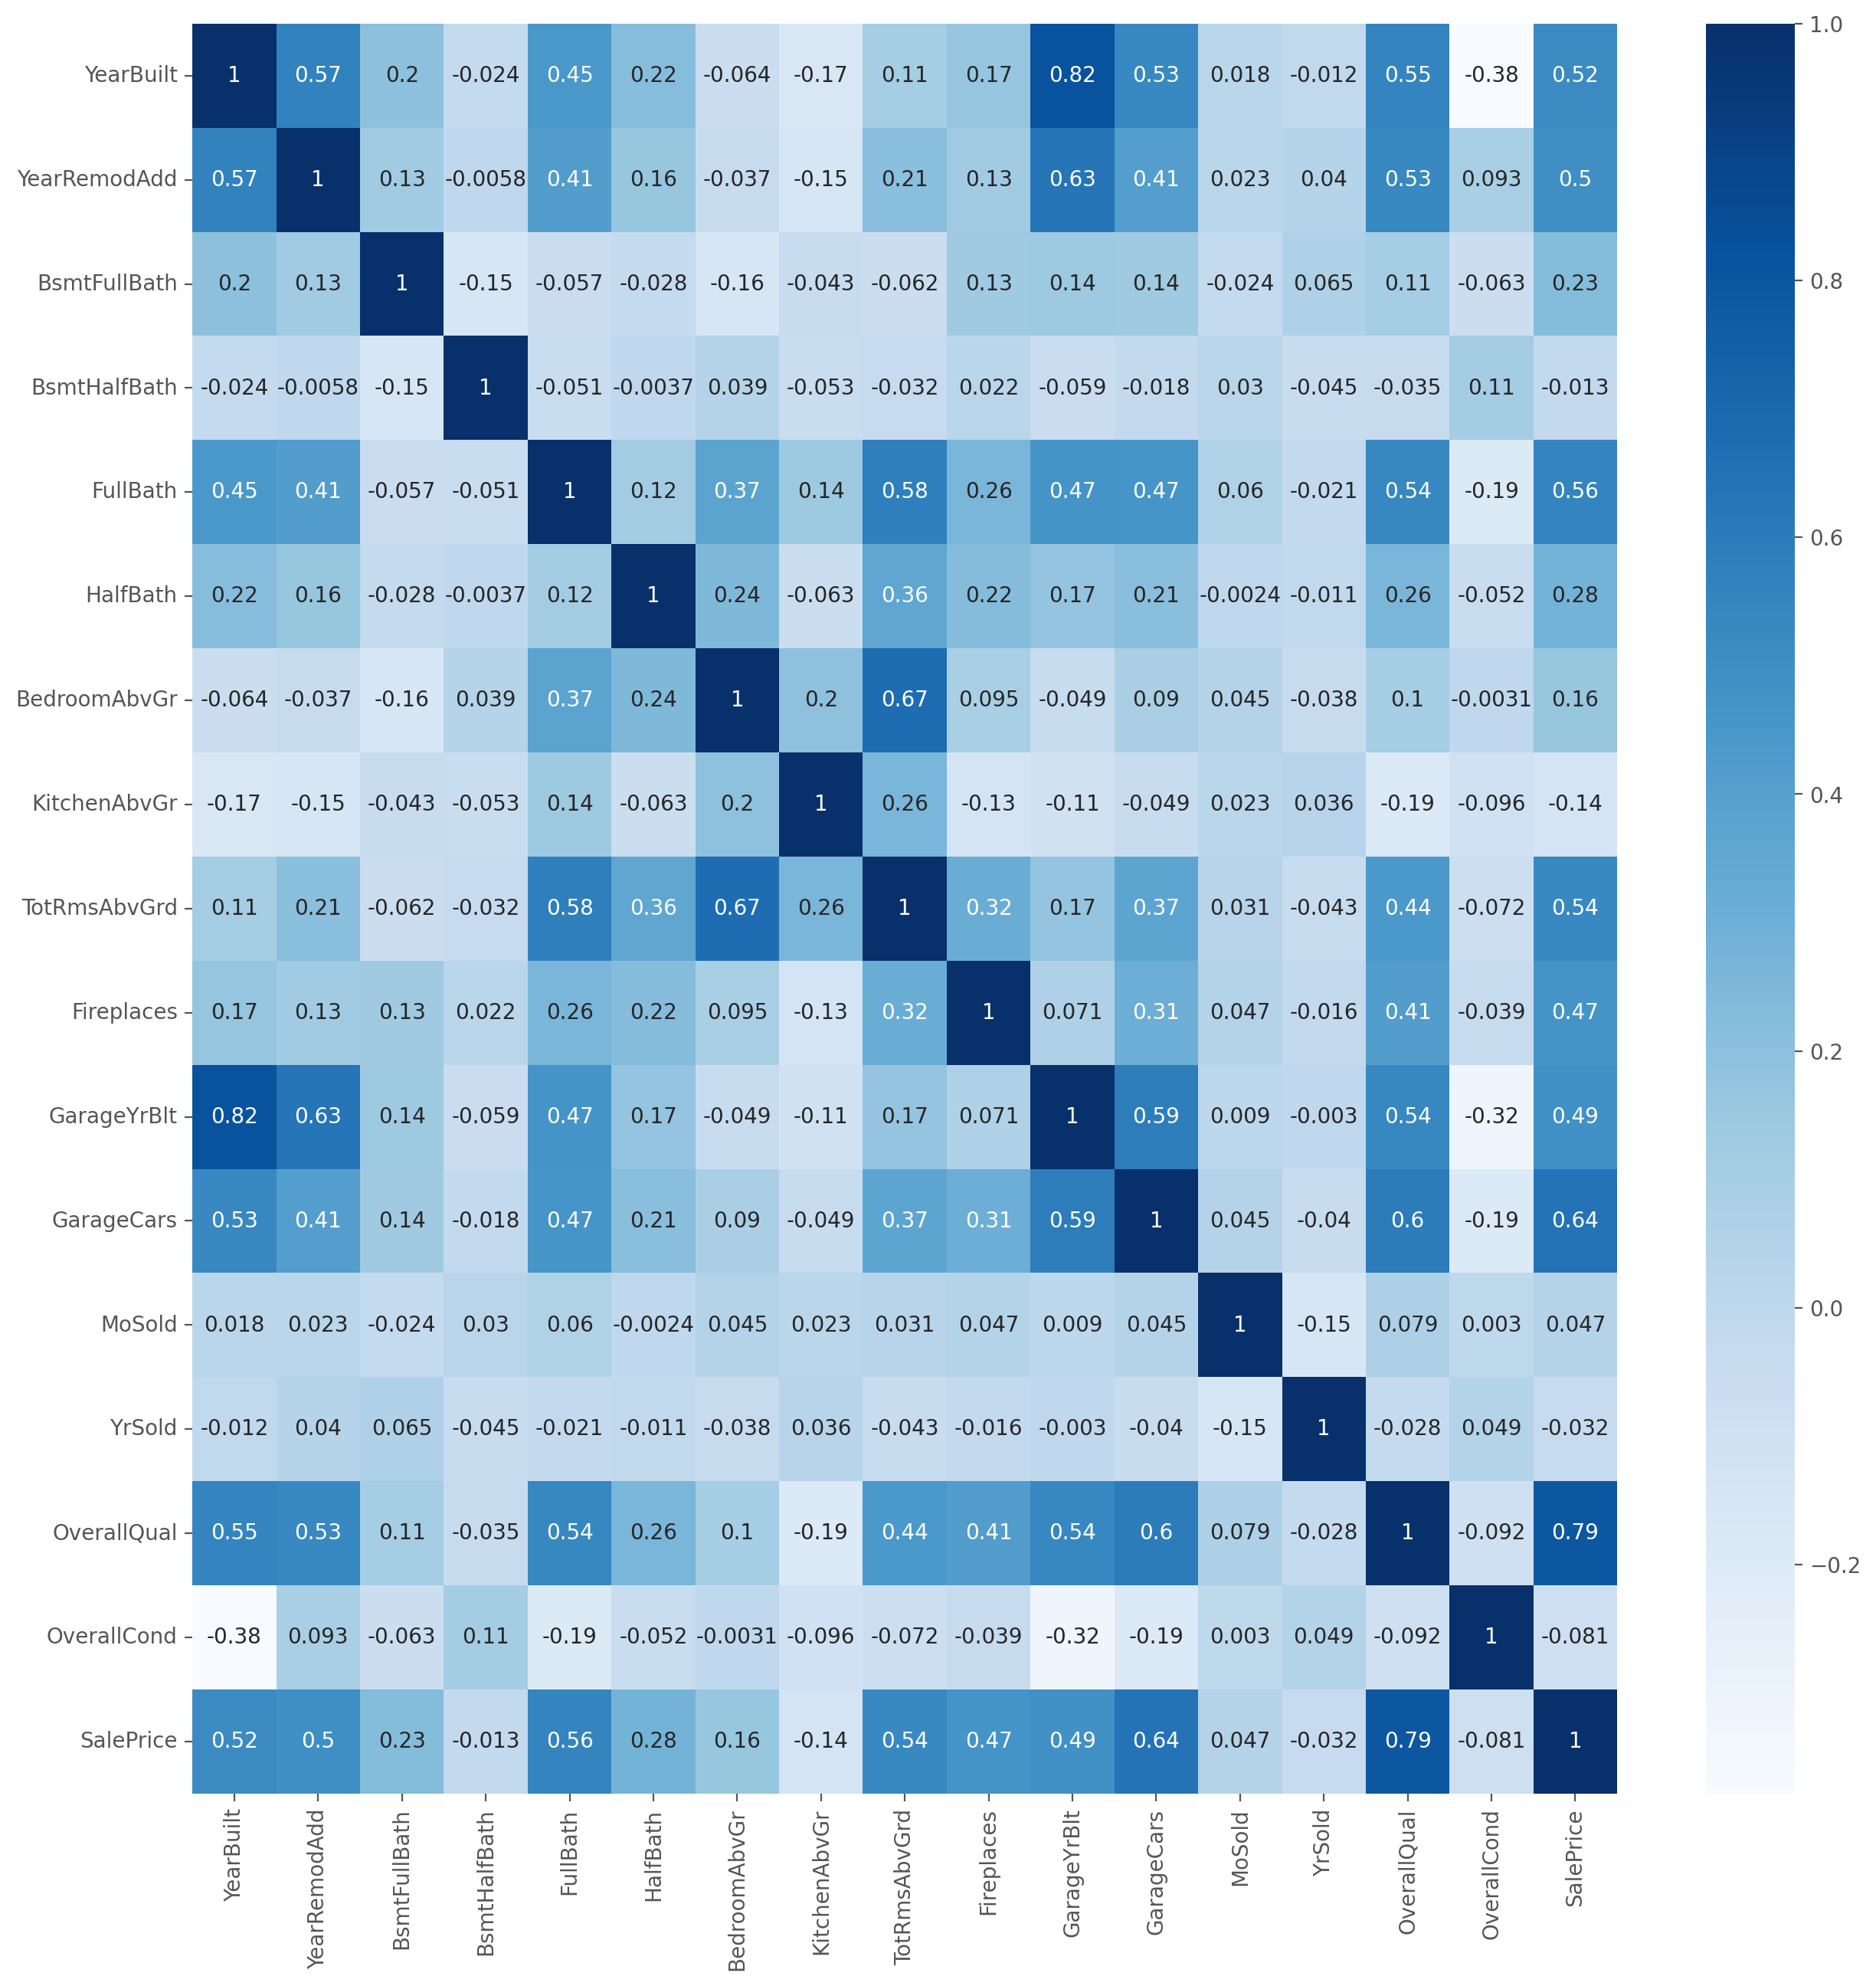

In [36]:
# explore correlations between discrete variables, ordinal variables and price

plt.figure(figsize=(15, 15))
sns.heatmap(house[discrete_vars+ordinal_vars+price].corr(), cmap='Blues', annot=True)
plt.show;

In [39]:
cont_vars_sub = ['TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageArea']

disc_vars_sub = ['FullBath', 'TotRmsAbvGrd', 'GarageCars', 'OverallQual']

<Figure size 1500x1500 with 0 Axes>

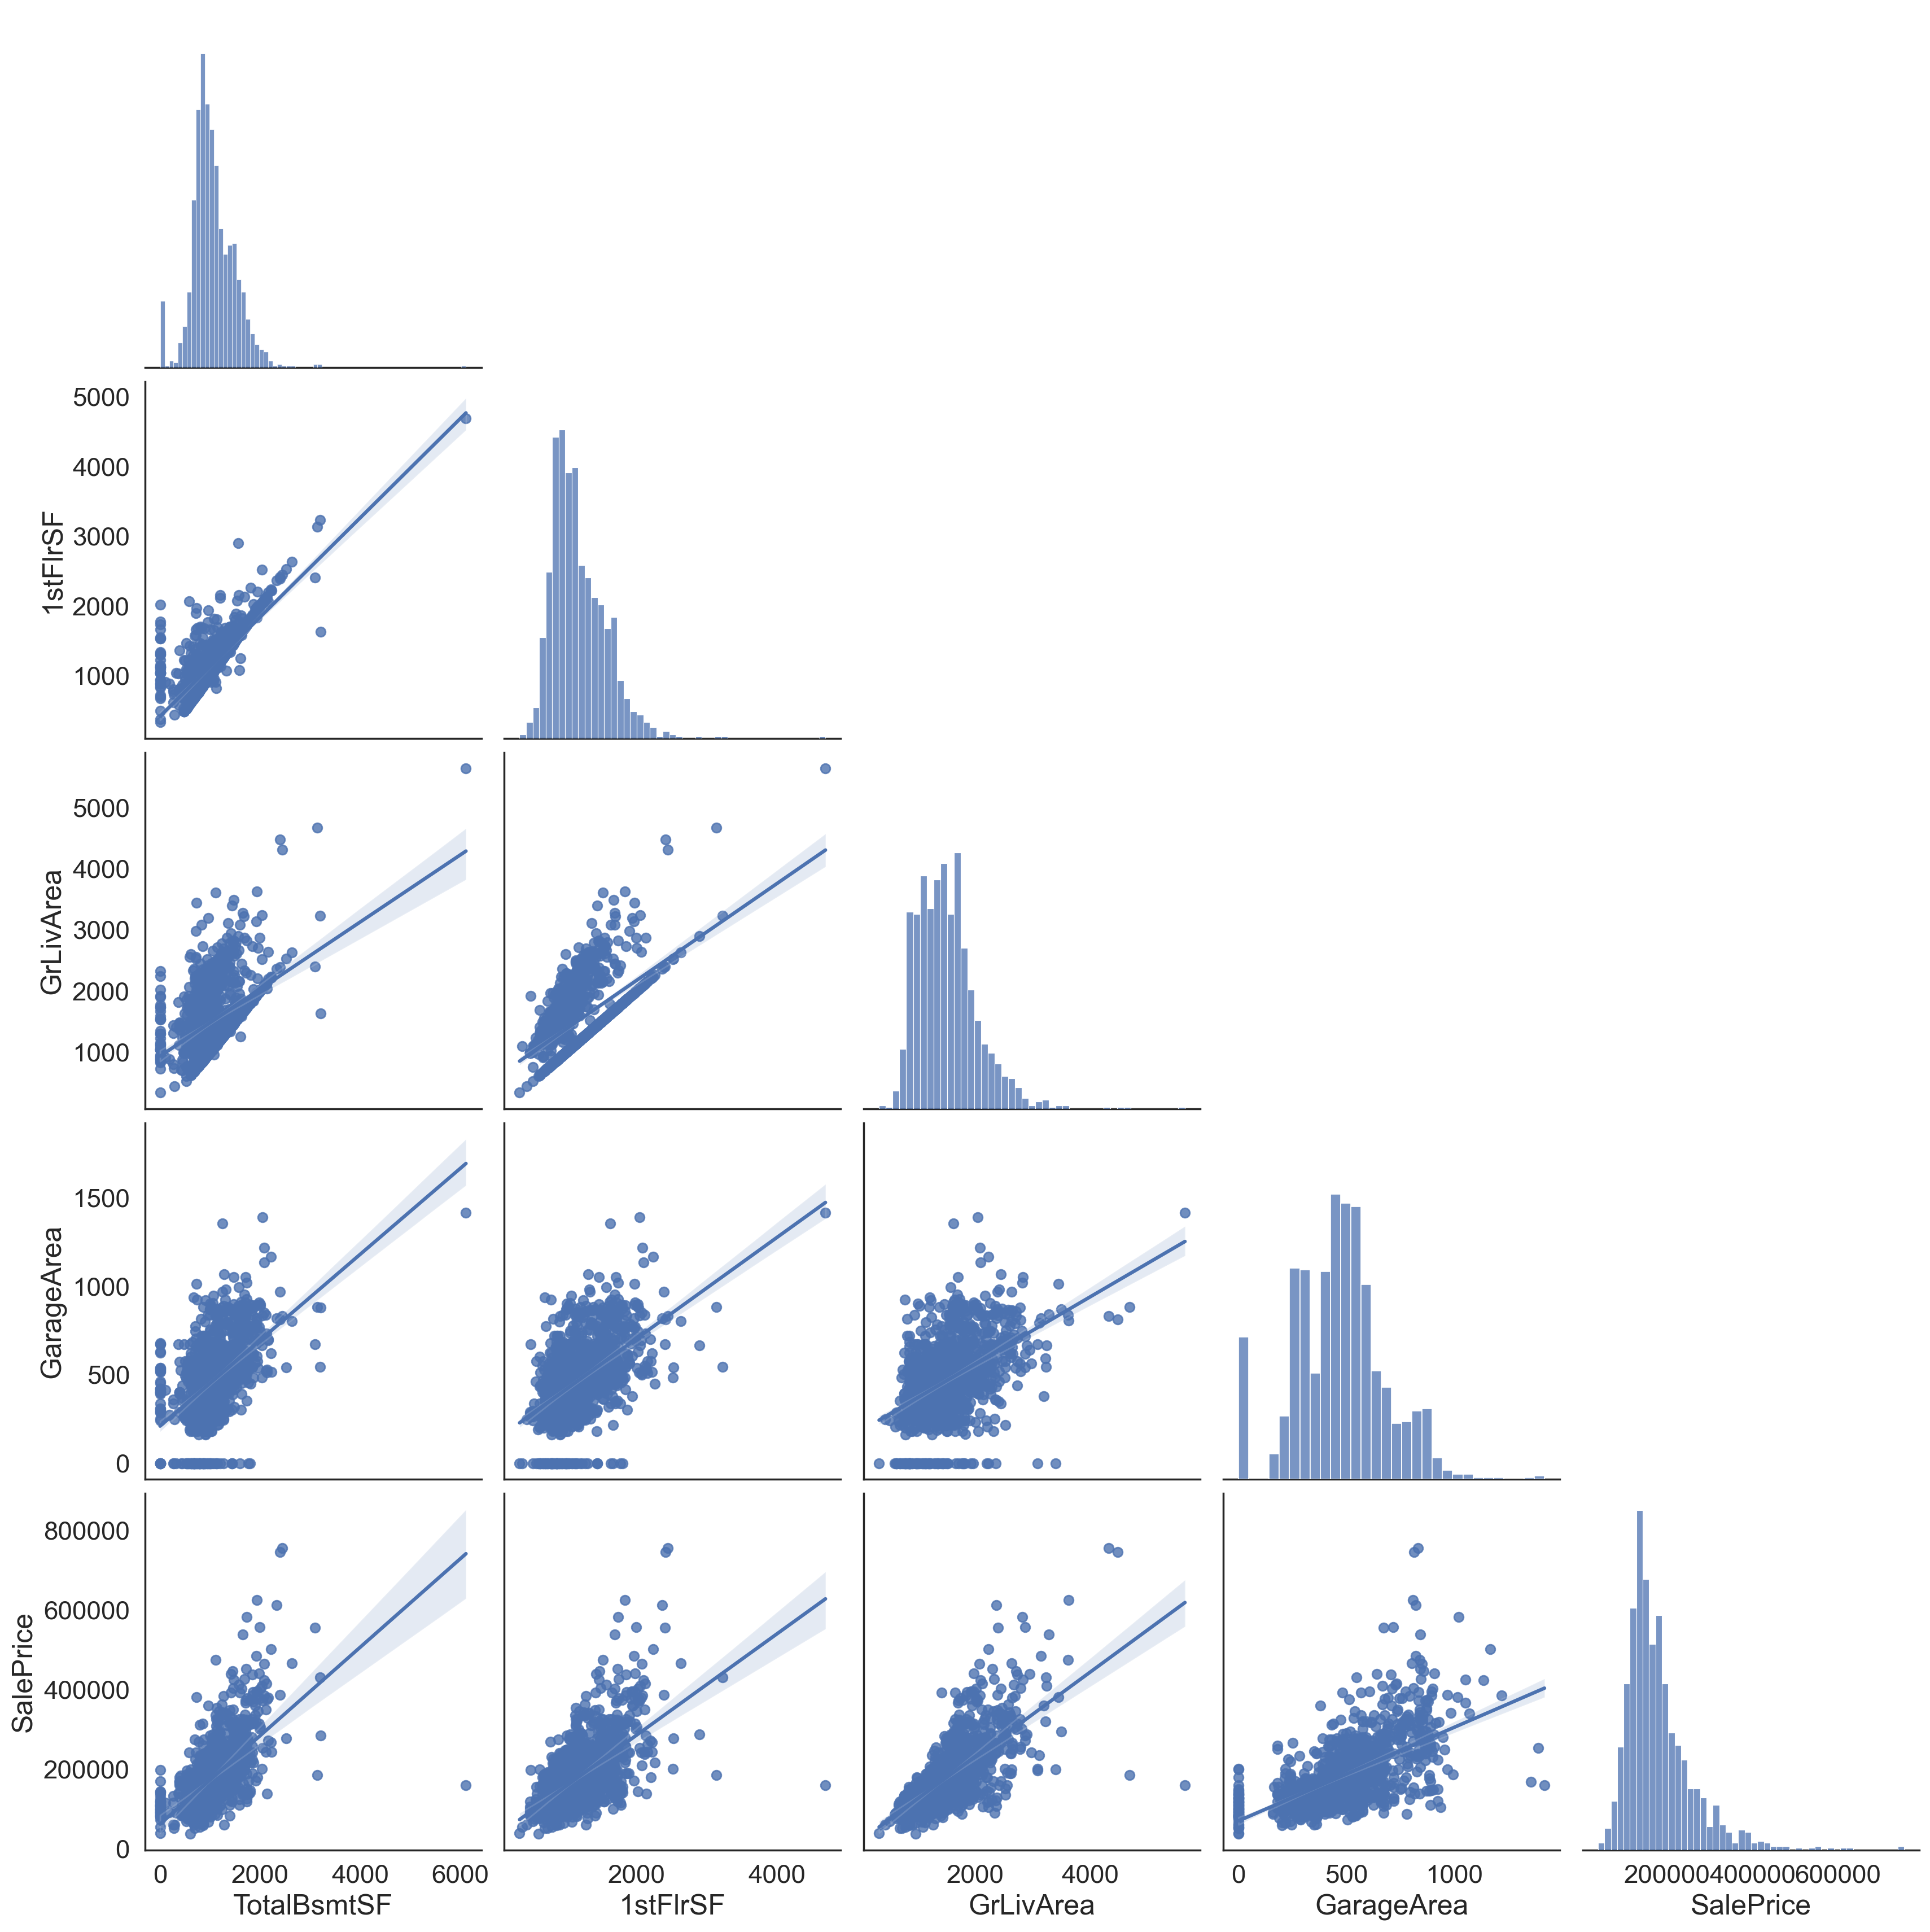

In [47]:
sns.set_theme(style='white' , font_scale=1.5)

plt.figure(figsize=(15, 15))

sns.pairplot(house[cont_vars_sub+price], kind='reg', height=3.5, plot_kws=dict(marker="o"),diag_kws=dict(fill=True),
             corner=True);


<Figure size 1500x1500 with 0 Axes>

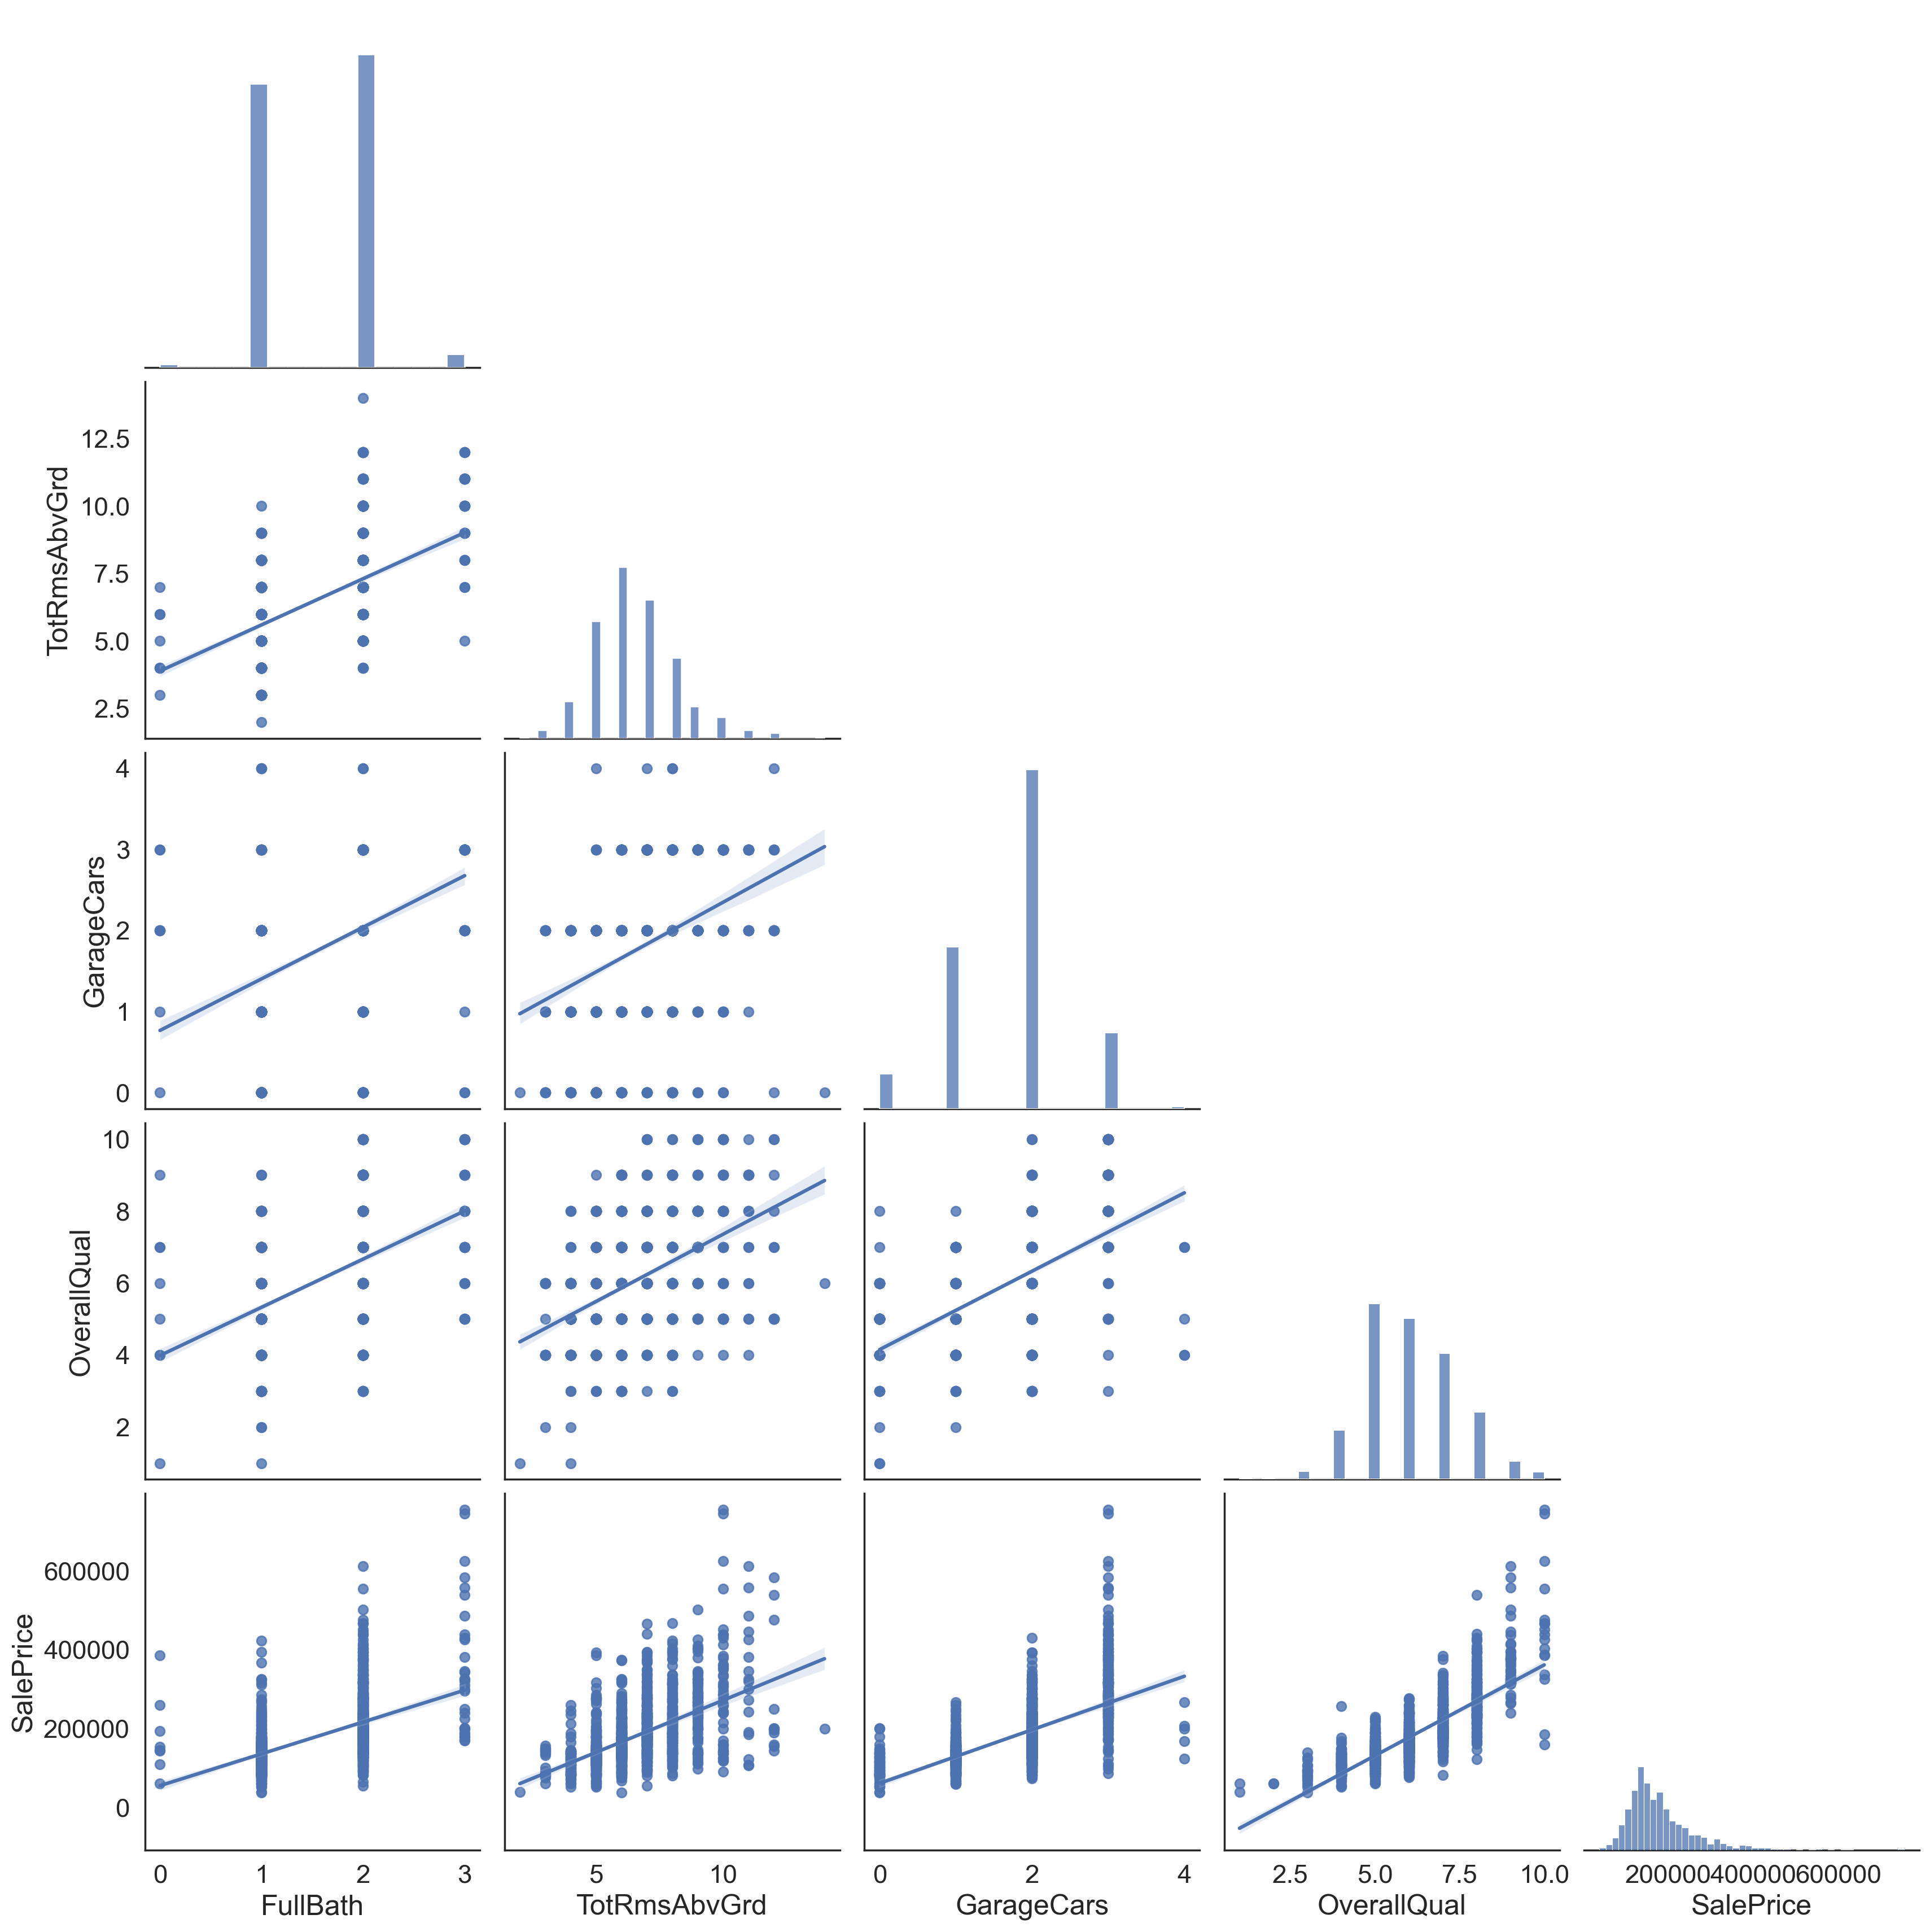

In [48]:
sns.set_theme(style='white' , font_scale=1.5)

plt.figure(figsize=(15, 15))

sns.pairplot(house[disc_vars_sub+price], kind='reg', height=3.5, plot_kws=dict(marker="o"),diag_kws=dict(fill=True),
             corner=True);


In [54]:
# drop rows with missing values for MasVnrType, MasVnrArea, Electrical

house = house[(house['MasVnrType'].notnull()) & (house['MasVnrArea'].notnull()) & (house['Electrical'].notnull())]

In [56]:
house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1379 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1379 non-null   int64  
 1   MSZoning       1379 non-null   object 
 2   LotFrontage    1130 non-null   float64
 3   LotArea        1379 non-null   int64  
 4   Street         1379 non-null   object 
 5   Alley          1379 non-null   object 
 6   LotShape       1379 non-null   object 
 7   LandContour    1379 non-null   object 
 8   Utilities      1379 non-null   object 
 9   LotConfig      1379 non-null   object 
 10  LandSlope      1379 non-null   object 
 11  Neighborhood   1379 non-null   object 
 12  Condition1     1379 non-null   object 
 13  Condition2     1379 non-null   object 
 14  BldgType       1379 non-null   object 
 15  HouseStyle     1379 non-null   object 
 16  OverallQual    1379 non-null   int64  
 17  OverallCond    1379 non-null   int64  
 18  YearBuil

In [105]:
from sklearn.preprocessing import StandardScaler

In [106]:
scaler = StandardScaler()

In [57]:
null_data = house[house.isnull().any(axis=1)]

In [58]:
null_data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
7,60,RL,NaN,10382,Pave,No,IR1,Lvl,AllPub,Corner,...,0,No,No,Shed,350,11,2009,WD,Normal,200000
12,20,RL,NaN,12968,Pave,No,IR2,Lvl,AllPub,Inside,...,0,No,No,No,0,9,2008,WD,Normal,144000
14,20,RL,NaN,10920,Pave,No,IR1,Lvl,AllPub,Corner,...,0,No,GdWo,No,0,5,2008,WD,Normal,157000
16,20,RL,NaN,11241,Pave,No,IR1,Lvl,AllPub,CulDSac,...,0,No,No,Shed,700,3,2010,WD,Normal,149000
24,20,RL,NaN,8246,Pave,No,IR1,Lvl,AllPub,Inside,...,0,No,MnPrv,No,0,5,2010,WD,Normal,154000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1443,30,RL,NaN,8854,Pave,No,Reg,Lvl,AllPub,Inside,...,0,No,No,No,0,5,2009,WD,Normal,121000
1446,20,RL,NaN,26142,Pave,No,IR1,Lvl,AllPub,CulDSac,...,0,No,No,No,0,4,2010,WD,Normal,157900
1449,180,RM,21.0,1533,Pave,No,Reg,Lvl,AllPub,Inside,...,0,No,No,No,0,8,2006,WD,Abnorml,92000
1450,90,RL,60.0,9000,Pave,No,Reg,Lvl,AllPub,FR2,...,0,No,No,No,0,9,2009,WD,Normal,136000


In [ ]:
# Identify fixed features that can predict price.

"""

For the fixed features I have not only considered the ones that cannot be renovated, but also the ones that are unlikely
to be renovated by the real estate company because of the huge cost involved.


LotFrontage
LotArea
LandContour
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
OverallQual
OverallCond
BsmtQual
TotalBsmtSF
1stFlrSF
2ndFlrSF
GrLivArea
BsmtFullBath
BsmtHalfBath
FullBath
HalfBath
BedroomAbvGr
KitchenAbvGr
TotRmsAbvGrd
Fireplaces
GarageType
GarageArea

"""



In [83]:
# copy the original dataframe.
# the new dataframe will be used for initial modelling

df = house.copy().reset_index()
df

,index,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0,60,RL,65.0,8450,Pave,No,Reg,Lvl,AllPub,...,0,No,No,No,0,2,2008,WD,Normal,208500
1,1,20,RL,80.0,9600,Pave,No,Reg,Lvl,AllPub,...,0,No,No,No,0,5,2007,WD,Normal,181500
2,2,60,RL,68.0,11250,Pave,No,IR1,Lvl,AllPub,...,0,No,No,No,0,9,2008,WD,Normal,223500
3,3,70,RL,60.0,9550,Pave,No,IR1,Lvl,AllPub,...,0,No,No,No,0,2,2006,WD,Abnorml,140000
4,4,60,RL,84.0,14260,Pave,No,IR1,Lvl,AllPub,...,0,No,No,No,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1374,1455,60,RL,62.0,7917,Pave,No,Reg,Lvl,AllPub,...,0,No,No,No,0,8,2007,WD,Normal,175000
1375,1456,20,RL,85.0,13175,Pave,No,Reg,Lvl,AllPub,...,0,No,MnPrv,No,0,2,2010,WD,Normal,210000
1376,1457,70,RL,66.0,9042,Pave,No,Reg,Lvl,AllPub,...,0,No,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1377,1458,20,RL,68.0,9717,Pave,No,Reg,Lvl,AllPub,...,0,No,No,No,0,4,2010,WD,Normal,142125


In [84]:
from sklearn.impute import KNNImputer

impute_knn = KNNImputer(n_neighbors=2)

In [85]:
# impute missing values in LotFrontage using the most correlated features

imp_LF = df[['LotFrontage', '1stFlrSF', 'LotArea', 'GrLivArea']].copy()
imp_LF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1379 entries, 0 to 1378
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   LotFrontage  1130 non-null   float64
 1   1stFlrSF     1379 non-null   int64  
 2   LotArea      1379 non-null   int64  
 3   GrLivArea    1379 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 43.2 KB


In [86]:
imp_LF = impute_knn.fit_transform(imp_LF)

In [87]:
cols = ['LotFrontage', '1stFlrSF', 'LotArea', 'GrLivArea']

imp_LF = pd.DataFrame(data=imp_LF, columns=cols)
imp_LF

,LotFrontage,1stFlrSF,LotArea,GrLivArea
0,65.0,856.0,8450.0,1710.0
1,80.0,1262.0,9600.0,1262.0
2,68.0,920.0,11250.0,1786.0
3,60.0,961.0,9550.0,1717.0
4,84.0,1145.0,14260.0,2198.0
...,...,...,...,...
1374,62.0,953.0,7917.0,1647.0
1375,85.0,2073.0,13175.0,2073.0
1376,66.0,1188.0,9042.0,2340.0
1377,68.0,1078.0,9717.0,1078.0


In [88]:
imp_LF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1379 entries, 0 to 1378
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   LotFrontage  1379 non-null   float64
 1   1stFlrSF     1379 non-null   float64
 2   LotArea      1379 non-null   float64
 3   GrLivArea    1379 non-null   float64
dtypes: float64(4)
memory usage: 43.2 KB


In [89]:
# impute missing values in GarageYrBlt using the most correlated features

imp_GY = df[['GarageYrBlt', 'YearBuilt', 'YearRemodAdd', 'GarageCars']].copy()
imp_GY.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1379 entries, 0 to 1378
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   GarageYrBlt   1300 non-null   float64
 1   YearBuilt     1379 non-null   int64  
 2   YearRemodAdd  1379 non-null   int64  
 3   GarageCars    1379 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 43.2 KB


In [90]:
imp_GY = impute_knn.fit_transform(imp_GY)

In [91]:
cols = ['GarageYrBlt', 'YearBuilt', 'YearRemodAdd', 'GarageCars']

imp_GY = pd.DataFrame(data=imp_GY, columns=cols)
imp_GY

,GarageYrBlt,YearBuilt,YearRemodAdd,GarageCars
0,2003.0,2003.0,2003.0,2.0
1,1976.0,1976.0,1976.0,2.0
2,2001.0,2001.0,2002.0,2.0
3,1998.0,1915.0,1970.0,3.0
4,2000.0,2000.0,2000.0,3.0
...,...,...,...,...
1374,1999.0,1999.0,2000.0,2.0
1375,1978.0,1978.0,1988.0,2.0
1376,1941.0,1941.0,2006.0,1.0
1377,1950.0,1950.0,1996.0,1.0


In [92]:
imp_GY.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1379 entries, 0 to 1378
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   GarageYrBlt   1379 non-null   float64
 1   YearBuilt     1379 non-null   float64
 2   YearRemodAdd  1379 non-null   float64
 3   GarageCars    1379 non-null   float64
dtypes: float64(4)
memory usage: 43.2 KB


In [93]:
# replace columns in the original dataframe

df['LotFrontage'] = imp_LF['LotFrontage']
df['GarageYrBlt'] = imp_GY['GarageYrBlt']

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1379 entries, 0 to 1378
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          1379 non-null   int64  
 1   MSSubClass     1379 non-null   int64  
 2   MSZoning       1379 non-null   object 
 3   LotFrontage    1379 non-null   float64
 4   LotArea        1379 non-null   int64  
 5   Street         1379 non-null   object 
 6   Alley          1379 non-null   object 
 7   LotShape       1379 non-null   object 
 8   LandContour    1379 non-null   object 
 9   Utilities      1379 non-null   object 
 10  LotConfig      1379 non-null   object 
 11  LandSlope      1379 non-null   object 
 12  Neighborhood   1379 non-null   object 
 13  Condition1     1379 non-null   object 
 14  Condition2     1379 non-null   object 
 15  BldgType       1379 non-null   object 
 16  HouseStyle     1379 non-null   object 
 17  OverallQual    1379 non-null   int64  
 18  OverallC

In [120]:
fixed_features = ['LotFrontage', 'LotArea', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
                  'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'BsmtQual', 'TotalBsmtSF',
                  '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
                  'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageType', 'GarageArea']

fixed_cat_vars = [x for x in df.columns if x in fixed_features and x in categ_vars]


In [121]:
fixed_cat_vars

['LandContour',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'BsmtQual',
 'GarageType']

In [130]:
other_features = [x for x in df.columns if x not in fixed_features and x != 'SalePrice']

In [131]:
other_features

['index',
 'MSSubClass',
 'MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'Utilities',
 'YearBuilt',
 'YearRemodAdd',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'LowQualFinSF',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SaleType',
 'SaleCondition']

In [104]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [122]:
# dummify the categorical variables

df_dum = pd.get_dummies(df, columns=fixed_cat_vars, drop_first=True)


In [123]:
df_dum.head()

,index,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,Utilities,YearBuilt,...,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_No,BsmtQual_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_No
0,0,60,RL,65.0,8450,Pave,No,Reg,AllPub,2003,...,0,1,0,0,1,0,0,0,0,0
1,1,20,RL,80.0,9600,Pave,No,Reg,AllPub,1976,...,0,1,0,0,1,0,0,0,0,0
2,2,60,RL,68.0,11250,Pave,No,IR1,AllPub,2001,...,0,1,0,0,1,0,0,0,0,0
3,3,70,RL,60.0,9550,Pave,No,IR1,AllPub,1915,...,0,0,0,1,0,0,0,0,1,0
4,4,60,RL,84.0,14260,Pave,No,IR1,AllPub,2000,...,0,1,0,0,1,0,0,0,0,0


In [124]:
# define target variable

y = df_dum.pop('SalePrice')

In [132]:
# define predictor matrix

X = df_dum.drop(columns=other_features)

In [133]:
X.head()

,LotFrontage,LotArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,...,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_No,BsmtQual_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_No
0,65.0,8450,856,856,854,1710,1,0,2,1,...,0,1,0,0,1,0,0,0,0,0
1,80.0,9600,1262,1262,0,1262,0,1,2,0,...,0,1,0,0,1,0,0,0,0,0
2,68.0,11250,920,920,866,1786,1,0,2,1,...,0,1,0,0,1,0,0,0,0,0
3,60.0,9550,756,961,756,1717,1,0,1,0,...,0,0,0,1,0,0,0,0,1,0
4,84.0,14260,1145,1145,1053,2198,1,0,2,1,...,0,1,0,0,1,0,0,0,0,0


In [135]:
df_dum.YrSold.value_counts()

2009    320
2007    312
2006    298
2008    286
2010    163
Name: YrSold, dtype: int64

In [136]:
# create train and test sets based on YrSold

X_train = X[df_dum.YrSold < 2010]
X_test = X[df_dum.YrSold == 2010]

y_train = y[df_dum.YrSold < 2010]
y_test = y[df_dum.YrSold == 2010]

In [137]:
# train and test set baseline

print(y_train.value_counts(normalize=True).max())
print(y_test.value_counts(normalize=True).max())

0.013980263157894737
0.018404907975460124


In [138]:
# rescale the dataset

scaler = StandardScaler()

In [139]:
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [140]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1216, 101)
(163, 101)
(1216,)
(163,)


In [141]:
# instatiate the model
model = LinearRegression()

# fit the model
model.fit(X_train, y_train)

# score the model
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.8816311706460236
0.8730985405739371


In [145]:
print('Intercept:', model.intercept_)

lr_coeffs = pd.DataFrame(list(zip(X_train.columns, model.coef_)))
lr_coeffs

Intercept: 180157.15789473685


,0,1
0,LotFrontage,-4058.995521
1,LotArea,5432.305010
2,TotalBsmtSF,1511.249326
3,1stFlrSF,7377.610150
4,2ndFlrSF,15821.569244
...,...,...
96,GarageType_Basment,4322.948713
97,GarageType_BuiltIn,6822.528469
98,GarageType_CarPort,221.056441
99,GarageType_Detchd,9385.895381


In [149]:
# best estimate of price

lr_coeffs[lr_coeffs[1]==lr_coeffs[1].max()]

,0,1
80,OverallQual_8,19049.607245


In [152]:
# best estimates of price

lr_coeffs.nlargest(5,[1])

,0,1
80,OverallQual_8,19049.607245
82,OverallQual_10,18800.008189
81,OverallQual_9,18201.148586
4,2ndFlrSF,15821.569244
79,OverallQual_7,14774.016701


In [153]:
# worst estimates of price

lr_coeffs.nsmallest(5,[1])

,0,1
94,BsmtQual_TA,-15472.752077
92,BsmtQual_Gd,-13161.825823
40,Neighborhood_OldTown,-9170.376583
30,Neighborhood_Edwards,-8700.974939
59,Condition2_PosN,-8427.768399


In [151]:
# perform 5-fold cross validation

scores = cross_val_score(model, X, y, cv=5)
print("Cross-validated scores:", scores)
print("Mean of Ccoss-validated scores:", scores.mean())

Cross-validated scores: [0.89404821 0.85803218 0.84391348 0.85991008 0.70085371]
Mean of Ccoss-validated scores: 0.8313515297156944


In [3]:
# A:

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovatable features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [ ]:
"""

I am going to use the changeable features in the predictor matrix and fit a new model.


"""

In [154]:
# copy the updated dataframe to create a new predictor matrix

df2 = df.copy().reset_index()
df2

,level_0,index,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0,0,60,RL,65.0,8450,Pave,No,Reg,Lvl,...,0,No,No,No,0,2,2008,WD,Normal,208500
1,1,1,20,RL,80.0,9600,Pave,No,Reg,Lvl,...,0,No,No,No,0,5,2007,WD,Normal,181500
2,2,2,60,RL,68.0,11250,Pave,No,IR1,Lvl,...,0,No,No,No,0,9,2008,WD,Normal,223500
3,3,3,70,RL,60.0,9550,Pave,No,IR1,Lvl,...,0,No,No,No,0,2,2006,WD,Abnorml,140000
4,4,4,60,RL,84.0,14260,Pave,No,IR1,Lvl,...,0,No,No,No,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1374,1374,1455,60,RL,62.0,7917,Pave,No,Reg,Lvl,...,0,No,No,No,0,8,2007,WD,Normal,175000
1375,1375,1456,20,RL,85.0,13175,Pave,No,Reg,Lvl,...,0,No,MnPrv,No,0,2,2010,WD,Normal,210000
1376,1376,1457,70,RL,66.0,9042,Pave,No,Reg,Lvl,...,0,No,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1377,1377,1458,20,RL,68.0,9717,Pave,No,Reg,Lvl,...,0,No,No,No,0,4,2010,WD,Normal,142125


In [155]:
df2.drop(columns=['level_0', 'index'], inplace=True)
df2

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,No,Reg,Lvl,AllPub,Inside,...,0,No,No,No,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,No,Reg,Lvl,AllPub,FR2,...,0,No,No,No,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,No,IR1,Lvl,AllPub,Inside,...,0,No,No,No,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,No,IR1,Lvl,AllPub,Corner,...,0,No,No,No,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,No,IR1,Lvl,AllPub,FR2,...,0,No,No,No,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1374,60,RL,62.0,7917,Pave,No,Reg,Lvl,AllPub,Inside,...,0,No,No,No,0,8,2007,WD,Normal,175000
1375,20,RL,85.0,13175,Pave,No,Reg,Lvl,AllPub,Inside,...,0,No,MnPrv,No,0,2,2010,WD,Normal,210000
1376,70,RL,66.0,9042,Pave,No,Reg,Lvl,AllPub,Inside,...,0,No,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1377,20,RL,68.0,9717,Pave,No,Reg,Lvl,AllPub,Inside,...,0,No,No,No,0,4,2010,WD,Normal,142125


In [4]:
# A:

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. It is recommended to do some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [5]:
# A: